In [1]:
from __future__ import print_function
import glob
from itertools import chain
import os
import cv2
import csv
import random
import zipfile
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from functools import reduce
import torch.nn as nn
from einops import rearrange, repeat
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import pandas as pd
from torchvision.transforms import ToPILImage
# from linformer import Linformer
from PIL import Image
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
# from vit_pytorch.efficient import ViT
# from model import BiSeNet
import torchvision.transforms as transforms
from skimage import io, img_as_float
import timm
from sklearn.metrics import log_loss, f1_score, roc_auc_score, accuracy_score
from timesformer.models.vit import TimeSformer


In [2]:
seed = 17
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [3]:
device = 'cuda'
# device = 'cpu'

In [4]:
fakeavceleb_paths_df = pd.read_csv('Video_File_Path_Dictionaries/fakeavceleb_paths.csv')
celebdf_paths_df = pd.read_csv('Video_File_Path_Dictionaries/celebdf_paths.csv')
dfdc_paths_df = pd.read_csv('Video_File_Path_Dictionaries/dfdc_paths.csv')
faceswap_paths_df = pd.read_csv('Video_File_Path_Dictionaries/ff_paths.csv')


In [5]:
test_set_paths_dictionary = {
                            'FakeAVCeleb': [fakeavceleb_paths_df['Path'], fakeavceleb_paths_df['Label']], 
                            'DFDC': [dfdc_paths_df['Path'], dfdc_paths_df['Label']],
                            'CelebDFV2': [celebdf_paths_df['Path'], celebdf_paths_df['Label']],
                            'FaceForensics': [faceswap_paths_df['Path'], faceswap_paths_df['Label']]
                            }

In [6]:
import timm
models = ['TimeSformer', 'ResNet']
augs = ['No_Augmentations', 'Random_Cut_Out_Augs']
datasets = ['FakeAVCeleb', 'FaceForensics', 'DFDC', 'CelebDFV2']


In [7]:
def get_scores(predictions):
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for key, value in predictions.items():
        predicted_probs.append(value[0])
        true_labels.append(value[2])
        predicted_labels.append(value[1])

    logloss = log_loss(true_labels, predicted_probs)
    auc = roc_auc_score(true_labels, predicted_probs)
    f1 = f1_score(true_labels, predicted_labels)
    
    return logloss, auc, f1

def Evaluate(model, vids_path_dict, dataset, save_path):
    videos = vids_path_dict[dataset][0]
    count = 0
    labels_map = ["fake", "real"]
    predictions = {}
    probs = {}
    tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    for vid in videos:
        fake_prob = 0
        real_prob = 0
        originallabel = None
        if 'fake' in vid.split('/')[-2]:
            originallabel = 0
        elif 'real' in vid.split('/')[-2]:
            originallabel = 1
        count+=1
        print(count)
        images = sorted(glob.glob(vid + '/*.png'))
        images = [path.replace('\\','/') for path in images]
        concated_images_per_video = torch.zeros(1, 3, 224, 224)
        for i in range(8):
            img_path = images[i]
            img = Image.open(img_path)
            img_transformed = tfms(img)
            img_transformed = img_transformed.unsqueeze(0)
            concated_images_per_video = torch.cat((concated_images_per_video, img_transformed), dim=0)
        concated_images_per_video = concated_images_per_video[1:]
        concated_images_per_video = concated_images_per_video.permute(1, 0, 2, 3)
        with torch.no_grad():
            outputs = model(concated_images_per_video.unsqueeze(0).to('cuda'))
        predicted_prob = []
        predicted_label = None
        for idx in torch.topk(outputs[0], k=1).indices.tolist():
            prob = torch.softmax(outputs[0], 0)[idx].item()
        if labels_map[idx] == 'fake':
            predicted_prob = 1 - prob
            print(predicted_prob)
            predictions[vid] = [predicted_prob, 0, originallabel]
        else:
            predicted_prob = prob
            print(predicted_prob)
            predictions[vid] = [predicted_prob, 1, originallabel]
        print('--------------')
        
    if 'neuraltextures' in vid:
        originallabel = 'NeuralTextures'
    elif 'face2face' in vid:
        originallabel = 'Face2Face'
    elif 'deepfakes' in vid:
        originallabel = 'DeepFakes'
    elif 'faceswap' in vid:
        originallabel = 'FaceSwap'
        
    with open(save_path + '.csv', 'w') as csvfile:
        fieldnames = ['VidPath', 'ProbabilityScore', 'PredictedLabel', 'OriginalLabel']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)
        writer.writeheader()
        for i in range(len(predictions)):
            vid = list(predictions)[i]
            writer.writerow({'VidPath': list(predictions)[i], 'ProbabilityScore': predictions[vid][0], 'PredictedLabel': predictions[vid][1], 'OriginalLabel': predictions[vid][2]})
    
    logloss, auc, f1 = get_scores(predictions)
    fieldnames = ['LogLoss','AUC','F1-Score']
    with open(save_path + '.csv', 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)
        writer.writeheader()
        writer.writerow({'LogLoss': logloss, 'AUC': auc, 'F1-Score': f1})
    torch.cuda.empty_cache()
    #     break

In [9]:
for i in range(4):
    no_evaluation_on = datasets[i]
#     print("NO EVALUATION DATASET IS: ", no_evaluation_on)
    for model_name in models:
        for dataset in datasets:
#             if no_evaluation_on == dataset:
            if 1 == 2:
                pass
            else:
                # Load model weights
                PATH = '../model_weights/supervised_models/' + model_name + '/' + augs[1] + '/' + no_evaluation_on + '/' + '/'
                for file in os.listdir(PATH):
                    if file.endswith(".pth"):
                        model_path = os.path.join(PATH, file)
                        model_path = model_path.replace("//", "/")
                        print(model_path)
                        if "TimeSformer" == model_name:
                            model = TimeSformer(img_size=224, num_classes=2, num_frames=8, attention_type='divided_space_time',
                                               pretrained_model='../video_model_pretraining_weights/TimeSformer_divST_8x32_224_K400.pyth')
                        else:
                            model = torch.hub.load('facebookresearch/pytorchvideo', 'slow_r50', model_num_class=2)
                        model.load_state_dict(torch.load(model_path), strict=True)
                        model.to(device)
                        model.eval()
                        print("loaded " + model_name + " weights!")
                        
                        if dataset == 'FakeAVCeleb':
                            #Evaluation code
                            print('Evaluating ' + model_name + ' on ' + dataset + ' trained on ' + no_evaluation_on)
                            save_path = ('CrossEvaluationTestScores/Video_by_Video_Evaluation/' + model_name + '_trained_on_' + 
                                         no_evaluation_on + '_evaluated_on_' + dataset)
                            Evaluate(model, test_set_paths_dictionary, dataset, save_path)

                        elif dataset == 'DFDC':
                            print('Evaluating ' + model_name + ' on ' + dataset + ' trained on ' + no_evaluation_on)
                            save_path = ('CrossEvaluationTestScores/Video_by_Video_Evaluation/' + model_name + '_trained_on_' + 
                                         no_evaluation_on + '_evaluated_on_' + dataset)
                            Evaluate(model, test_set_paths_dictionary, dataset, save_path)
                            
                        elif dataset == 'CelebDFV2':
                            print('Evaluating ' + model_name + ' on ' + dataset + ' trained on ' + no_evaluation_on)
                            save_path = ('CrossEvaluationTestScores/Video_by_Video_Evaluation/' + model_name + '_trained_on_' + 
                                         no_evaluation_on + '_evaluated_on_' + dataset)
                            Evaluate(model, test_set_paths_dictionary, dataset, save_path)
                            
                        elif dataset == 'FaceForensics':
                            print('Evaluating ' + model_name + ' on ' + dataset + ' trained on ' + no_evaluation_on)
                            save_path = ('CrossEvaluationTestScores/Video_by_Video_Evaluation/' + model_name + '_trained_on_' + 
                                         no_evaluation_on + '_evaluated_on_' + dataset)
                            Evaluate(model, test_set_paths_dictionary, dataset, save_path)
                                
                        print('====================================================================================================')
    print('')
    print('')

../model_weights/supervised_models/TimeSformer/Random_Cut_Out_Augs/FakeAVCeleb/3_epochs.pth
loaded TimeSformer weights!
Evaluating TimeSformer on FakeAVCeleb trained on FakeAVCeleb
1
0.04816603660583496
--------------
2
0.9999889135360718
--------------
3
0.9999583959579468
--------------
4
0.9999713897705078
--------------
5
0.9999983310699463
--------------
6
0.9993762373924255
--------------
7
0.9924986958503723
--------------
8
0.9999504089355469
--------------
9
0.9968066215515137
--------------
10
0.9999994039535522
--------------
11
0.9949640035629272
--------------
12
0.9999964237213135
--------------
13
0.9649876952171326
--------------
14
0.99979168176651
--------------
15
0.4532621502876282
--------------
16
0.9999896287918091
--------------
17
0.9984554052352905
--------------
18
0.9999997615814209
--------------
19
0.9999998807907104
--------------
20
0.9999990463256836
--------------
21
0.9998759031295776
--------------
22
0.9973388314247131
--------------
23
0.9999995231

0.9999990463256836
--------------
3
0.9999970197677612
--------------
4
0.9999996423721313
--------------
5
0.9999977350234985
--------------
6
0.9999991655349731
--------------
7
0.9999997615814209
--------------
8
0.9999979734420776
--------------
9
0.9999996423721313
--------------
10
0.9999998807907104
--------------
11
0.9999996423721313
--------------
12
0.9999986886978149
--------------
13
0.999976396560669
--------------
14
0.9999995231628418
--------------
15
0.9999929666519165
--------------
16
0.9999996423721313
--------------
17
0.999998927116394
--------------
18
0.9994331002235413
--------------
19
0.9999997615814209
--------------
20
0.9999997615814209
--------------
21
0.9999954700469971
--------------
22
1.0
--------------
23
0.9865841269493103
--------------
24
0.9999812841415405
--------------
25
0.9999992847442627
--------------
26
0.9999963045120239
--------------
27
0.9999973773956299
--------------
28
0.9999998807907104
--------------
29
0.9999995231628418
------

0.9999979734420776
--------------
224
0.9999991655349731
--------------
225
0.9999980926513672
--------------
226
0.9999933242797852
--------------
227
0.9997606873512268
--------------
228
0.9999991655349731
--------------
229
0.9999980926513672
--------------
230
0.9999990463256836
--------------
231
0.9999998807907104
--------------
232
0.9999994039535522
--------------
233
0.999993085861206
--------------
234
0.9999997615814209
--------------
235
0.9999982118606567
--------------
236
0.9587922692298889
--------------
237
0.9999997615814209
--------------
238
0.9999427795410156
--------------
239
1.0
--------------
240
0.24624478816986084
--------------
241
0.999859094619751
--------------
242
0.9998910427093506
--------------
243
0.9999977350234985
--------------
244
0.9408532381057739
--------------
245
0.9999995231628418
--------------
246
0.9999992847442627
--------------
247
0.9999908208847046
--------------
248
1.0
--------------
249
0.994703471660614
--------------
250
0.9999

0.9999827146530151
--------------
161
0.999924898147583
--------------
162
0.9999799728393555
--------------
163
0.9999998807907104
--------------
164
0.9999949932098389
--------------
165
0.9999927282333374
--------------
166
0.9998887777328491
--------------
167
0.9962034821510315
--------------
168
0.9999997615814209
--------------
169
0.9999961853027344
--------------
170
0.9999983310699463
--------------
171
0.9999998807907104
--------------
172
0.9999138116836548
--------------
173
0.9983174800872803
--------------
174
0.999991774559021
--------------
175
0.9999198913574219
--------------
176
0.9999994039535522
--------------
177
0.9999927282333374
--------------
178
0.9999985694885254
--------------
179
0.9999997615814209
--------------
180
0.9999765157699585
--------------
181
0.9991297125816345
--------------
182
0.9999977350234985
--------------
183
0.9999983310699463
--------------
184
0.9999936819076538
--------------
185
0.9986070990562439
--------------
186
0.999999880790

0.9631698131561279
--------------
380
0.9999334812164307
--------------
381
0.9436705112457275
--------------
382
0.9067012667655945
--------------
383
0.999990701675415
--------------
384
0.9999902248382568
--------------
385
0.999941349029541
--------------
386
0.08704882860183716
--------------
387
0.9999998807907104
--------------
388
0.9995743632316589
--------------
389
0.6967014074325562
--------------
390
0.9997742772102356
--------------
391
0.9987828135490417
--------------
392
0.9999998807907104
--------------
393
0.8323941230773926
--------------
394
0.9999997615814209
--------------
395
0.999680757522583
--------------
396
0.9997566342353821
--------------
397
0.9999761581420898
--------------
398
0.9961223006248474
--------------
399
0.9999961853027344
--------------
400
0.9999029636383057
--------------
../model_weights/supervised_models/TimeSformer/Random_Cut_Out_Augs/FakeAVCeleb/3_epochs.pth
loaded TimeSformer weights!
Evaluating TimeSformer on CelebDFV2 trained on Fak

Using cache found in C:\Users\Sohail/.cache\torch\hub\facebookresearch_pytorchvideo_main


loaded ResNet weights!
Evaluating ResNet on FakeAVCeleb trained on FakeAVCeleb
1
0.9984436631202698
--------------
2
0.9998574256896973
--------------
3
0.9994074106216431
--------------
4
0.9931414723396301
--------------
5
0.9999986886978149
--------------
6
0.9932034015655518
--------------
7
0.9999967813491821
--------------
8
0.999981164932251
--------------
9
0.9798521399497986
--------------
10
0.999792754650116
--------------
11
0.9998412132263184
--------------
12
0.9999997615814209
--------------
13
0.99978107213974
--------------
14
0.9948981404304504
--------------
15
0.9999927282333374
--------------
16
0.9999539852142334
--------------
17
0.9994080066680908
--------------
18
0.9999743700027466
--------------
19
0.9999885559082031
--------------
20
0.9999701976776123
--------------
21
0.9996414184570312
--------------
22
0.999524712562561
--------------
23
1.0
--------------
24
0.9157634973526001
--------------
25
0.9999977350234985
--------------
26
0.9999712705612183
---

Using cache found in C:\Users\Sohail/.cache\torch\hub\facebookresearch_pytorchvideo_main


loaded ResNet weights!
Evaluating ResNet on FaceForensics trained on FakeAVCeleb
1
0.9999953508377075
--------------
2
0.9999890327453613
--------------
3
0.9996032118797302
--------------
4
0.9999934434890747
--------------
5
0.9994693398475647
--------------
6
0.9999998807907104
--------------
7
0.9999997615814209
--------------
8
0.9999951124191284
--------------
9
0.9999997615814209
--------------
10
0.9991195797920227
--------------
11
0.9999945163726807
--------------
12
0.9996277093887329
--------------
13
0.999993085861206
--------------
14
0.9999526739120483
--------------
15
0.9993298053741455
--------------
16
0.9999935626983643
--------------
17
0.9999933242797852
--------------
18
0.9999997615814209
--------------
19
0.9999796152114868
--------------
20
1.0
--------------
21
0.9999995231628418
--------------
22
0.9999707937240601
--------------
23
0.9944868683815002
--------------
24
0.9998389482498169
--------------
25
0.999100923538208
--------------
26
0.999887228012085

0.9999997615814209
--------------
233
0.9999939203262329
--------------
234
0.9999997615814209
--------------
235
0.9999843835830688
--------------
236
0.9866982102394104
--------------
237
0.9999997615814209
--------------
238
0.9999648332595825
--------------
239
0.9999505281448364
--------------
240
0.9977374076843262
--------------
241
0.9999982118606567
--------------
242
0.9999830722808838
--------------
243
0.9999691247940063
--------------
244
0.9571598172187805
--------------
245
0.9999992847442627
--------------
246
0.9750691056251526
--------------
247
0.999809205532074
--------------
248
0.9999834299087524
--------------
249
0.9333176612854004
--------------
250
0.9999990463256836
--------------
251
0.9999861717224121
--------------
252
0.9999974966049194
--------------
253
0.9999995231628418
--------------
254
0.9358592629432678
--------------
255
0.9999799728393555
--------------
256
0.9999980926513672
--------------
257
0.9999045133590698
--------------
258
0.99994754791

Using cache found in C:\Users\Sohail/.cache\torch\hub\facebookresearch_pytorchvideo_main


loaded ResNet weights!
Evaluating ResNet on DFDC trained on FakeAVCeleb
1
0.9496164917945862
--------------
2
0.999221682548523
--------------
3
1.0
--------------
4
0.9999490976333618
--------------
5
0.9999785423278809
--------------
6
0.9978992938995361
--------------
7
0.9999654293060303
--------------
8
0.9999992847442627
--------------
9
0.0017875432968139648
--------------
10
0.9999910593032837
--------------
11
0.9998089671134949
--------------
12
0.996282160282135
--------------
13
0.9998262524604797
--------------
14
0.9985490441322327
--------------
15
0.9999946355819702
--------------
16
0.9999849796295166
--------------
17
0.9999871253967285
--------------
18
0.9999992847442627
--------------
19
0.9999997615814209
--------------
20
0.9999967813491821
--------------
21
0.999977707862854
--------------
22
0.9942837357521057
--------------
23
0.9995002746582031
--------------
24
0.9999566078186035
--------------
25
0.0033742189407348633
--------------
26
0.9999984502792358
--

0.9999994039535522
--------------
228
0.00012803077697753906
--------------
229
0.9999265670776367
--------------
230
2.384185791015625e-07
--------------
231
0.9999994039535522
--------------
232
0.9697290062904358
--------------
233
0.9998761415481567
--------------
234
0.9999128580093384
--------------
235
0.9999927282333374
--------------
236
0.9999971389770508
--------------
237
0.9994226694107056
--------------
238
0.9999161958694458
--------------
239
0.9999712705612183
--------------
240
0.9987714886665344
--------------
241
0.9999282360076904
--------------
242
0.0014088749885559082
--------------
243
0.9999672174453735
--------------
244
0.9999921321868896
--------------
245
0.9999969005584717
--------------
246
0.006739199161529541
--------------
247
1.5616416931152344e-05
--------------
248
0.9999995231628418
--------------
249
0.0007061958312988281
--------------
250
0.7745060324668884
--------------
251
0.9998674392700195
--------------
252
0.9994781613349915
------------

Using cache found in C:\Users\Sohail/.cache\torch\hub\facebookresearch_pytorchvideo_main


loaded ResNet weights!
Evaluating ResNet on CelebDFV2 trained on FakeAVCeleb
1
0.3242625594139099
--------------
2
0.9948129653930664
--------------
3
0.9941904544830322
--------------
4
0.029452860355377197
--------------
5
0.9954038858413696
--------------
6
0.9397794008255005
--------------
7
0.9993826150894165
--------------
8
0.9977298378944397
--------------
9
0.6448327302932739
--------------
10
0.06877344846725464
--------------
11
0.999874472618103
--------------
12
0.17719358205795288
--------------
13
0.9969925880432129
--------------
14
0.9929581880569458
--------------
15
0.9961394667625427
--------------
16
0.001459360122680664
--------------
17
0.8997818827629089
--------------
18
0.9999761581420898
--------------
19
0.9954206347465515
--------------
20
0.019977569580078125
--------------
21
0.9999858140945435
--------------
22
0.5848789811134338
--------------
23
0.9997177720069885
--------------
24
0.9999685287475586
--------------
25
0.9999057054519653
--------------


0.30106693506240845
--------------
112
3.123283386230469e-05
--------------
113
0.004018425941467285
--------------
114
0.04829972982406616
--------------
115
0.004317522048950195
--------------
116
0.0021911263465881348
--------------
117
0.011576235294342041
--------------
118
0.00036454200744628906
--------------
119
0.2623862624168396
--------------
120
1.3113021850585938e-06
--------------
121
0.6157878637313843
--------------
122
0.007204711437225342
--------------
123
7.462501525878906e-05
--------------
124
0.011264026165008545
--------------
125
0.6142120957374573
--------------
126
0.946861743927002
--------------
127
0.00010395050048828125
--------------
128
0.0003228187561035156
--------------
129
0.006200969219207764
--------------
130
0.1828187108039856
--------------
131
0.07410424947738647
--------------
132
0.08808284997940063
--------------
133
0.08372795581817627
--------------
134
0.0019811391830444336
--------------
135
0.34766095876693726
--------------
136
0.8209

0.998462438583374
--------------
120
0.9440430402755737
--------------
121
0.6737886667251587
--------------
122
0.9993670582771301
--------------
123
0.978803813457489
--------------
124
0.9335391521453857
--------------
125
0.9992642998695374
--------------
126
0.7713758945465088
--------------
127
0.012453019618988037
--------------
128
0.997570812702179
--------------
129
0.9904566407203674
--------------
130
0.9063712954521179
--------------
131
0.9038843512535095
--------------
132
0.995648205280304
--------------
133
0.1806582808494568
--------------
134
0.9998905658721924
--------------
135
0.9994033575057983
--------------
136
0.9995794892311096
--------------
137
0.9972847700119019
--------------
138
0.9958004355430603
--------------
139
0.9968658089637756
--------------
140
0.9555975794792175
--------------
141
0.010351955890655518
--------------
142
7.987022399902344e-06
--------------
143
0.000799715518951416
--------------
144
6.318092346191406e-06
--------------
145
0.00

0.9959418177604675
--------------
42
0.010984838008880615
--------------
43
0.9688578844070435
--------------
44
0.38670527935028076
--------------
45
0.6569859981536865
--------------
46
0.008329391479492188
--------------
47
0.929165244102478
--------------
48
0.08497577905654907
--------------
49
0.9589027762413025
--------------
50
0.0007317662239074707
--------------
51
0.9564139246940613
--------------
52
0.2145087718963623
--------------
53
0.9924001693725586
--------------
54
0.9005105495452881
--------------
55
0.9933318495750427
--------------
56
0.006304323673248291
--------------
57
0.14763814210891724
--------------
58
0.027693212032318115
--------------
59
0.9748950004577637
--------------
60
0.01376652717590332
--------------
61
0.9699360132217407
--------------
62
0.9999107122421265
--------------
63
0.9993952512741089
--------------
64
0.9998231530189514
--------------
65
0.9841824173927307
--------------
66
0.002058565616607666
--------------
67
0.8956394195556641
---

0.9989742040634155
--------------
257
0.002770721912384033
--------------
258
0.1106463074684143
--------------
259
0.12416237592697144
--------------
260
0.0015905499458312988
--------------
261
0.5388772487640381
--------------
262
0.0019168853759765625
--------------
263
0.0053868889808654785
--------------
264
0.8666272163391113
--------------
265
0.014712810516357422
--------------
266
0.007919490337371826
--------------
267
0.01542806625366211
--------------
268
0.45715343952178955
--------------
269
0.5117267966270447
--------------
270
0.21619069576263428
--------------
271
0.009034037590026855
--------------
272
0.002855241298675537
--------------
273
0.019520282745361328
--------------
274
0.0354839563369751
--------------
275
0.08434164524078369
--------------
276
0.0010156035423278809
--------------
277
0.4839719533920288
--------------
278
0.8340491056442261
--------------
279
0.0009821653366088867
--------------
280
0.009374856948852539
--------------
281
0.56272596120834

0.0001055002212524414
--------------
63
0.0004885196685791016
--------------
64
0.8644388318061829
--------------
65
0.13751602172851562
--------------
66
0.08945804834365845
--------------
67
1.4901161193847656e-05
--------------
68
0.00022917985916137695
--------------
69
0.18198835849761963
--------------
70
3.5762786865234375e-05
--------------
71
0.002925872802734375
--------------
72
0.181016206741333
--------------
73
0.15132570266723633
--------------
74
0.7145243883132935
--------------
75
1.811981201171875e-05
--------------
76
0.9075126647949219
--------------
77
0.6068147420883179
--------------
78
0.0982896089553833
--------------
79
0.10511225461959839
--------------
80
0.5165690779685974
--------------
81
0.0214502215385437
--------------
82
0.03879499435424805
--------------
83
0.016578614711761475
--------------
84
0.002281010150909424
--------------
85
0.0004812479019165039
--------------
86
0.18521267175674438
--------------
87
0.0633699893951416
--------------
88
0.

Using cache found in C:\Users\Sohail/.cache\torch\hub\facebookresearch_pytorchvideo_main


loaded ResNet weights!
Evaluating ResNet on FakeAVCeleb trained on FaceForensics
1
0.8660686016082764
--------------
2
0.9789766073226929
--------------
3
0.9999078512191772
--------------
4
0.8998401761054993
--------------
5
0.8990159630775452
--------------
6
0.9302005171775818
--------------
7
0.7126679420471191
--------------
8
0.9884350299835205
--------------
9
0.9102602601051331
--------------
10
0.9998977184295654
--------------
11
0.9899219870567322
--------------
12
0.994647204875946
--------------
13
0.9997087121009827
--------------
14
0.9974279999732971
--------------
15
0.7589167952537537
--------------
16
0.9996693134307861
--------------
17
0.9999198913574219
--------------
18
0.9996905326843262
--------------
19
0.9993854761123657
--------------
20
0.4204087257385254
--------------
21
0.9938673377037048
--------------
22
0.9992031455039978
--------------
23
0.9992702603340149
--------------
24
0.9301891922950745
--------------
25
0.9997231364250183
--------------
26
0

Using cache found in C:\Users\Sohail/.cache\torch\hub\facebookresearch_pytorchvideo_main


loaded ResNet weights!
Evaluating ResNet on FaceForensics trained on FaceForensics
1
0.9996906518936157
--------------
2
0.9999914169311523
--------------
3
0.9920220375061035
--------------
4
0.9896523356437683
--------------
5
0.9987847208976746
--------------
6
0.9999227523803711
--------------
7
0.9613026976585388
--------------
8
0.8537232875823975
--------------
9
0.9997923970222473
--------------
10
0.9999028444290161
--------------
11
0.9894888997077942
--------------
12
0.9999996423721313
--------------
13
0.999967098236084
--------------
14
0.9999998807907104
--------------
15
0.9981170892715454
--------------
16
0.9988221526145935
--------------
17
0.49245142936706543
--------------
18
0.9933215975761414
--------------
19
0.9998193383216858
--------------
20
0.010256826877593994
--------------
21
0.9999977350234985
--------------
22
0.9992989301681519
--------------
23
1.0
--------------
24
0.9999998807907104
--------------
25
0.9958208799362183
--------------
26
0.999812304

0.0037210583686828613
--------------
216
5.459785461425781e-05
--------------
217
0.0011698603630065918
--------------
218
0.009255588054656982
--------------
219
2.765655517578125e-05
--------------
220
0.009004056453704834
--------------
221
0.00010228157043457031
--------------
222
4.410743713378906e-06
--------------
223
0.0003864169120788574
--------------
224
7.033348083496094e-05
--------------
225
0.1466730833053589
--------------
226
0.027584314346313477
--------------
227
1.8477439880371094e-05
--------------
228
8.940696716308594e-06
--------------
229
0.001981019973754883
--------------
230
1.6689300537109375e-06
--------------
231
0.00018602609634399414
--------------
232
4.0531158447265625e-05
--------------
233
0.3543103337287903
--------------
234
0.003515005111694336
--------------
235
0.007108807563781738
--------------
236
0.987675666809082
--------------
237
0.001288771629333496
--------------
238
0.0013619065284729004
--------------
239
0.0003037452697753906
------

Using cache found in C:\Users\Sohail/.cache\torch\hub\facebookresearch_pytorchvideo_main


loaded ResNet weights!
Evaluating ResNet on DFDC trained on FaceForensics
1
0.9311620593070984
--------------
2
0.9994865655899048
--------------
3
0.8651071786880493
--------------
4
0.9993246793746948
--------------
5
0.9970519542694092
--------------
6
0.8699868321418762
--------------
7
0.16204911470413208
--------------
8
0.8602713942527771
--------------
9
0.9990119934082031
--------------
10
0.9993820190429688
--------------
11
0.9954902529716492
--------------
12
0.9326967000961304
--------------
13
0.3768666386604309
--------------
14
0.2630211114883423
--------------
15
0.9999914169311523
--------------
16
0.9848699569702148
--------------
17
0.3136668801307678
--------------
18
0.2589098811149597
--------------
19
0.9964789748191833
--------------
20
0.9688465595245361
--------------
21
0.2443355917930603
--------------
22
0.9529338479042053
--------------
23
0.03505438566207886
--------------
24
0.740678071975708
--------------
25
0.8951570391654968
--------------
26
0.9999

0.28380513191223145
--------------
220
0.012375473976135254
--------------
221
0.8489456176757812
--------------
222
0.986011266708374
--------------
223
0.002525150775909424
--------------
224
0.0124281644821167
--------------
225
0.04296380281448364
--------------
226
0.5520116090774536
--------------
227
0.9988678693771362
--------------
228
0.00664907693862915
--------------
229
6.663799285888672e-05
--------------
230
0.4247463345527649
--------------
231
0.9990736246109009
--------------
232
0.011969268321990967
--------------
233
0.9958928823471069
--------------
234
0.9525874257087708
--------------
235
0.9998513460159302
--------------
236
0.5364748239517212
--------------
237
0.0003650188446044922
--------------
238
4.76837158203125e-06
--------------
239
0.22032254934310913
--------------
240
0.9968973398208618
--------------
241
0.000264585018157959
--------------
242
0.1484774947166443
--------------
243
0.3144304156303406
--------------
244
0.9795424938201904
------------

Using cache found in C:\Users\Sohail/.cache\torch\hub\facebookresearch_pytorchvideo_main


loaded ResNet weights!
Evaluating ResNet on CelebDFV2 trained on FaceForensics
1
0.5916789174079895
--------------
2
0.008096277713775635
--------------
3
0.016114115715026855
--------------
4
0.02131509780883789
--------------
5
0.03719896078109741
--------------
6
0.948528528213501
--------------
7
0.9683401584625244
--------------
8
0.8630177974700928
--------------
9
0.04768681526184082
--------------
10
0.885433554649353
--------------
11
0.9968509078025818
--------------
12
0.7412959933280945
--------------
13
0.008302092552185059
--------------
14
0.3252902626991272
--------------
15
0.053657472133636475
--------------
16
0.26245927810668945
--------------
17
0.9937073588371277
--------------
18
0.9990130662918091
--------------
19
0.5885165929794312
--------------
20
0.8812770247459412
--------------
21
0.999995231628418
--------------
22
0.9996587038040161
--------------
23
0.9945818781852722
--------------
24
0.0009011030197143555
--------------
25
0.06781572103500366
-------

0.9688345193862915
--------------
114
0.7998741269111633
--------------
115
0.0030487775802612305
--------------
116
0.333368182182312
--------------
117
0.35322922468185425
--------------
118
0.9667707681655884
--------------
119
0.22037512063980103
--------------
120
0.9617013335227966
--------------
121
0.8641605973243713
--------------
122
0.9579866528511047
--------------
123
0.20474272966384888
--------------
124
0.8110766410827637
--------------
125
0.6052519083023071
--------------
126
0.9955840706825256
--------------
127
0.00011849403381347656
--------------
128
0.0010830163955688477
--------------
129
0.5206729769706726
--------------
130
0.22434169054031372
--------------
131
0.944356381893158
--------------
132
0.7012077569961548
--------------
133
0.00373995304107666
--------------
134
0.18788105249404907
--------------
135
0.02849733829498291
--------------
136
0.9210046529769897
--------------
137
0.3611884117126465
--------------
138
0.718248724937439
--------------
13

0.9956235289573669
--------------
123
0.9621754288673401
--------------
124
0.31434720754623413
--------------
125
0.9801187515258789
--------------
126
0.9652115106582642
--------------
127
0.8071515560150146
--------------
128
0.8859429359436035
--------------
129
0.8695707321166992
--------------
130
0.641169011592865
--------------
131
0.003932595252990723
--------------
132
0.3213220238685608
--------------
133
0.611111581325531
--------------
134
0.9527272582054138
--------------
135
0.03235048055648804
--------------
136
0.006162703037261963
--------------
137
0.8607543706893921
--------------
138
0.4357095956802368
--------------
139
0.03235238790512085
--------------
140
0.07222455739974976
--------------
141
0.9936168193817139
--------------
142
0.8111166954040527
--------------
143
0.00022453069686889648
--------------
144
0.22263240814208984
--------------
145
0.10154879093170166
--------------
146
0.9833526611328125
--------------
147
0.9867104887962341
--------------
148


0.9947355389595032
--------------
51
0.9300699830055237
--------------
52
0.9909997582435608
--------------
53
0.9477823972702026
--------------
54
0.9977173805236816
--------------
55
0.9998511075973511
--------------
56
0.7321608662605286
--------------
57
0.9838473200798035
--------------
58
0.9640843868255615
--------------
59
0.9830922484397888
--------------
60
0.416736364364624
--------------
61
0.923045814037323
--------------
62
0.9962068796157837
--------------
63
0.7953668832778931
--------------
64
0.9848101735115051
--------------
65
0.21336203813552856
--------------
66
0.9733686447143555
--------------
67
0.853649914264679
--------------
68
0.9750564098358154
--------------
69
0.9987342953681946
--------------
70
0.9982529282569885
--------------
71
0.9489036202430725
--------------
72
0.9967353940010071
--------------
73
0.9625529050827026
--------------
74
0.9940885305404663
--------------
75
0.9947998523712158
--------------
76
0.9949398040771484
--------------
77
0.9

0.9850938320159912
--------------
267
0.004072606563568115
--------------
268
0.012370944023132324
--------------
269
0.9686951041221619
--------------
270
0.44853299856185913
--------------
271
0.9499104619026184
--------------
272
0.9780734181404114
--------------
273
0.3055623173713684
--------------
274
0.897558331489563
--------------
275
0.03418236970901489
--------------
276
0.15700727701187134
--------------
277
0.0003821849822998047
--------------
278
5.4001808166503906e-05
--------------
279
4.9948692321777344e-05
--------------
280
0.0858997106552124
--------------
281
0.00040417909622192383
--------------
282
1.1444091796875e-05
--------------
283
0.0584789514541626
--------------
284
0.9894535541534424
--------------
285
0.3354562520980835
--------------
286
0.8327086567878723
--------------
287
0.24742090702056885
--------------
288
0.0062364935874938965
--------------
289
0.0016210079193115234
--------------
290
0.00010728836059570312
--------------
291
0.945169806480407

0.07698965072631836
--------------
73
6.091594696044922e-05
--------------
74
0.8908224701881409
--------------
75
0.012573957443237305
--------------
76
0.9146557450294495
--------------
77
0.5181841254234314
--------------
78
0.4749629497528076
--------------
79
0.09713327884674072
--------------
80
0.028990089893341064
--------------
81
0.01349174976348877
--------------
82
0.015156686305999756
--------------
83
0.5500229597091675
--------------
84
0.9378765821456909
--------------
85
0.2697528600692749
--------------
86
0.010587751865386963
--------------
87
0.05973941087722778
--------------
88
0.0012345314025878906
--------------
89
0.9986677169799805
--------------
90
0.942103922367096
--------------
91
0.9890986680984497
--------------
92
0.00407862663269043
--------------
93
0.340731680393219
--------------
94
0.5004168152809143
--------------
95
8.106231689453125e-06
--------------
96
4.875659942626953e-05
--------------
97
0.09981298446655273
--------------
98
1.728534698486

Using cache found in C:\Users\Sohail/.cache\torch\hub\facebookresearch_pytorchvideo_main


loaded ResNet weights!
Evaluating ResNet on FakeAVCeleb trained on DFDC
1
0.42019110918045044
--------------
2
0.4228208065032959
--------------
3
0.3308389186859131
--------------
4
0.28570759296417236
--------------
5
0.9996834993362427
--------------
6
0.995481014251709
--------------
7
0.9310603737831116
--------------
8
0.9594225883483887
--------------
9
0.8416832089424133
--------------
10
0.9911449551582336
--------------
11
0.34649431705474854
--------------
12
0.999796450138092
--------------
13
0.9399303793907166
--------------
14
0.9714875221252441
--------------
15
0.9842308163642883
--------------
16
0.9606490135192871
--------------
17
0.731147289276123
--------------
18
0.9528152346611023
--------------
19
0.9204034805297852
--------------
20
0.9948339462280273
--------------
21
0.2946345806121826
--------------
22
0.8599258065223694
--------------
23
0.983588695526123
--------------
24
0.3155674934387207
--------------
25
0.9374105930328369
--------------
26
0.93420344

Using cache found in C:\Users\Sohail/.cache\torch\hub\facebookresearch_pytorchvideo_main


loaded ResNet weights!
Evaluating ResNet on FaceForensics trained on DFDC
1
0.9387215375900269
--------------
2
0.005321145057678223
--------------
3
0.00929272174835205
--------------
4
0.7222122550010681
--------------
5
0.8745626211166382
--------------
6
0.3513195514678955
--------------
7
0.31050944328308105
--------------
8
0.0044678449630737305
--------------
9
0.10295403003692627
--------------
10
0.9996486902236938
--------------
11
0.9396759867668152
--------------
12
0.833232581615448
--------------
13
0.06490087509155273
--------------
14
0.9936909675598145
--------------
15
0.3396652936935425
--------------
16
0.46181803941726685
--------------
17
0.03993940353393555
--------------
18
0.9953670501708984
--------------
19
0.9656583070755005
--------------
20
0.9864480495452881
--------------
21
0.9958311915397644
--------------
22
0.9821863174438477
--------------
23
0.6317607164382935
--------------
24
0.6823312640190125
--------------
25
0.2105693817138672
--------------


0.005798757076263428
--------------
219
0.7523148655891418
--------------
220
0.12696486711502075
--------------
221
0.6964910626411438
--------------
222
0.8202692270278931
--------------
223
0.8512730598449707
--------------
224
0.14823031425476074
--------------
225
0.9259059429168701
--------------
226
0.014970481395721436
--------------
227
0.9981326460838318
--------------
228
0.9971174001693726
--------------
229
0.172846257686615
--------------
230
0.9660018086433411
--------------
231
0.38549870252609253
--------------
232
0.4215073585510254
--------------
233
0.0350612998008728
--------------
234
0.9980970025062561
--------------
235
0.27294182777404785
--------------
236
0.15021175146102905
--------------
237
0.9964776635169983
--------------
238
0.031245172023773193
--------------
239
0.19491970539093018
--------------
240
0.06659495830535889
--------------
241
0.8167524337768555
--------------
242
0.29885751008987427
--------------
243
0.18072229623794556
--------------
24

Using cache found in C:\Users\Sohail/.cache\torch\hub\facebookresearch_pytorchvideo_main


loaded ResNet weights!
Evaluating ResNet on DFDC trained on DFDC
1
0.9999998807907104
--------------
2
0.9956793189048767
--------------
3
0.5727948546409607
--------------
4
0.9998708963394165
--------------
5
0.9385653734207153
--------------
6
0.9657289981842041
--------------
7
0.189325213432312
--------------
8
0.8142358064651489
--------------
9
0.9999043941497803
--------------
10
0.9977245926856995
--------------
11
0.5860941410064697
--------------
12
0.25306111574172974
--------------
13
0.6852049827575684
--------------
14
0.04916495084762573
--------------
15
0.9999891519546509
--------------
16
0.9433714747428894
--------------
17
0.9999219179153442
--------------
18
0.6496890187263489
--------------
19
0.7600772976875305
--------------
20
0.5442461967468262
--------------
21
0.08658349514007568
--------------
22
0.9983096122741699
--------------
23
0.3160403370857239
--------------
24
0.8853241205215454
--------------
25
0.03159284591674805
--------------
26
0.99954384565

0.0020844340324401855
--------------
219
0.39832353591918945
--------------
220
0.05129951238632202
--------------
221
0.7261067628860474
--------------
222
0.7925949096679688
--------------
223
0.0037114620208740234
--------------
224
0.30670005083084106
--------------
225
0.03275114297866821
--------------
226
0.0009267330169677734
--------------
227
0.0007680654525756836
--------------
228
0.5973266959190369
--------------
229
0.6902231574058533
--------------
230
0.031080782413482666
--------------
231
0.9864940643310547
--------------
232
0.23601406812667847
--------------
233
0.03340482711791992
--------------
234
0.1762041449546814
--------------
235
0.9507800936698914
--------------
236
0.43326646089553833
--------------
237
0.01346522569656372
--------------
238
0.010551929473876953
--------------
239
0.535815417766571
--------------
240
0.011446833610534668
--------------
241
0.06771129369735718
--------------
242
0.09001201391220093
--------------
243
0.08066481351852417
---

Using cache found in C:\Users\Sohail/.cache\torch\hub\facebookresearch_pytorchvideo_main


loaded ResNet weights!
Evaluating ResNet on CelebDFV2 trained on DFDC
1
0.11706894636154175
--------------
2
0.9942283630371094
--------------
3
0.5916966199874878
--------------
4
0.7834540605545044
--------------
5
0.802585244178772
--------------
6
0.050100743770599365
--------------
7
0.9964828491210938
--------------
8
0.9540941119194031
--------------
9
0.9867494702339172
--------------
10
0.8539377450942993
--------------
11
0.9952322840690613
--------------
12
0.5211920142173767
--------------
13
0.9961614608764648
--------------
14
0.5435022115707397
--------------
15
0.5811243057250977
--------------
16
0.8466370701789856
--------------
17
0.8204513192176819
--------------
18
0.9810019135475159
--------------
19
0.8433005213737488
--------------
20
0.9319743514060974
--------------
21
0.9980592131614685
--------------
22
0.6209462881088257
--------------
23
0.9980657696723938
--------------
24
0.9125142097473145
--------------
25
0.9998441934585571
--------------
26
0.1517130

0.9999996423721313
--------------
118
0.9999616146087646
--------------
119
0.9999970197677612
--------------
120
0.9629237055778503
--------------
121
0.9999995231628418
--------------
122
0.9957625269889832
--------------
123
0.3295246958732605
--------------
124
0.9999974966049194
--------------
125
0.9999997615814209
--------------
126
0.999981164932251
--------------
127
0.9997808337211609
--------------
128
0.9999853372573853
--------------
129
0.968535840511322
--------------
130
0.9999959468841553
--------------
131
0.9999924898147583
--------------
132
0.9994639754295349
--------------
133
0.9994903802871704
--------------
134
0.8354735970497131
--------------
135
0.009295523166656494
--------------
136
1.0
--------------
137
0.9999998807907104
--------------
138
0.9999996423721313
--------------
139
0.9999904632568359
--------------
140
0.9999960660934448
--------------
141
1.0
--------------
142
0.9999289512634277
--------------
143
0.9999567270278931
--------------
144
0.98

0.9999947547912598
--------------
138
0.9999897480010986
--------------
139
0.9999980926513672
--------------
140
0.9999996423721313
--------------
141
0.9999997615814209
--------------
142
0.9999990463256836
--------------
143
0.9999995231628418
--------------
144
0.9998527765274048
--------------
145
0.37520933151245117
--------------
146
0.9999997615814209
--------------
147
0.9996838569641113
--------------
148
0.9998615980148315
--------------
149
0.9986722469329834
--------------
150
0.9999994039535522
--------------
151
0.9999990463256836
--------------
152
0.2104244828224182
--------------
153
0.999998927116394
--------------
154
0.9999909400939941
--------------
155
0.9999998807907104
--------------
156
0.9999997615814209
--------------
157
0.999998927116394
--------------
158
0.9999940395355225
--------------
159
0.42640167474746704
--------------
160
0.9999992847442627
--------------
161
0.9999992847442627
--------------
162
0.99774169921875
--------------
163
0.999999523162

0.9999865293502808
--------------
72
0.9999954700469971
--------------
73
0.9986214637756348
--------------
74
0.9999998807907104
--------------
75
0.9999992847442627
--------------
76
0.9999465942382812
--------------
77
0.9999843835830688
--------------
78
0.9995686411857605
--------------
79
0.9991381168365479
--------------
80
0.9999467134475708
--------------
81
0.9999866485595703
--------------
82
0.9999961853027344
--------------
83
0.9999616146087646
--------------
84
0.9857348203659058
--------------
85
0.47642093896865845
--------------
86
0.9999959468841553
--------------
87
0.9999972581863403
--------------
88
0.999998927116394
--------------
89
0.9999785423278809
--------------
90
0.9996657371520996
--------------
91
0.9999954700469971
--------------
92
0.9999997615814209
--------------
93
1.0
--------------
94
0.9975560903549194
--------------
95
0.9999891519546509
--------------
96
0.9999960660934448
--------------
97
0.9999974966049194
--------------
98
0.99999940395355

0.9999982118606567
--------------
294
0.9399236440658569
--------------
295
0.9999785423278809
--------------
296
0.9999967813491821
--------------
297
0.9945545196533203
--------------
298
0.9996631145477295
--------------
299
0.5061290860176086
--------------
300
0.9921531081199646
--------------
301
0.8075430393218994
--------------
302
0.9999982118606567
--------------
303
0.9999995231628418
--------------
304
0.9999933242797852
--------------
305
0.9978796243667603
--------------
306
0.9999879598617554
--------------
307
0.9999939203262329
--------------
308
0.9972670078277588
--------------
309
0.9984727501869202
--------------
310
0.0015580058097839355
--------------
311
0.39751899242401123
--------------
312
0.9978200197219849
--------------
313
0.9999938011169434
--------------
314
0.9993906021118164
--------------
315
0.9999444484710693
--------------
316
0.9805276393890381
--------------
317
0.9999998807907104
--------------
318
0.5935506224632263
--------------
319
0.999997

Using cache found in C:\Users\Sohail/.cache\torch\hub\facebookresearch_pytorchvideo_main


loaded ResNet weights!
Evaluating ResNet on FakeAVCeleb trained on CelebDFV2
1
0.9999698400497437
--------------
2
0.9999985694885254
--------------
3
0.9998347759246826
--------------
4
0.9999997615814209
--------------
5
0.9999994039535522
--------------
6
0.9999943971633911
--------------
7
1.0
--------------
8
0.9999988079071045
--------------
9
1.0
--------------
10
0.9999986886978149
--------------
11
1.0
--------------
12
1.0
--------------
13
0.9993640780448914
--------------
14
0.999983549118042
--------------
15
0.9999079704284668
--------------
16
1.0
--------------
17
0.9999704360961914
--------------
18
0.9999605417251587
--------------
19
1.0
--------------
20
1.0
--------------
21
0.9999464750289917
--------------
22
0.960039496421814
--------------
23
0.9999791383743286
--------------
24
0.9999982118606567
--------------
25
1.0
--------------
26
1.0
--------------
27
0.9999829530715942
--------------
28
0.997231662273407
--------------
29
1.0
--------------
30
0.9999995

Using cache found in C:\Users\Sohail/.cache\torch\hub\facebookresearch_pytorchvideo_main


loaded ResNet weights!
Evaluating ResNet on FaceForensics trained on CelebDFV2
1
1.0
--------------
2
0.9983198046684265
--------------
3
0.9999996423721313
--------------
4
0.9999736547470093
--------------
5
0.9999953508377075
--------------
6
1.0
--------------
7
0.9999895095825195
--------------
8
0.9998397827148438
--------------
9
1.0
--------------
10
1.0
--------------
11
0.9998051524162292
--------------
12
0.9991224408149719
--------------
13
0.9999997615814209
--------------
14
1.0
--------------
15
0.9999985694885254
--------------
16
0.9999984502792358
--------------
17
1.0
--------------
18
0.999992847442627
--------------
19
1.0
--------------
20
0.9999991655349731
--------------
21
0.9999794960021973
--------------
22
1.0
--------------
23
1.0
--------------
24
0.9999996423721313
--------------
25
0.9999998807907104
--------------
26
0.9999943971633911
--------------
27
0.9999997615814209
--------------
28
0.9999994039535522
--------------
29
0.9999964237213135
--------

0.9999997615814209
--------------
245
0.9999988079071045
--------------
246
0.9999998807907104
--------------
247
0.4187886118888855
--------------
248
1.0
--------------
249
0.9999998807907104
--------------
250
0.9998979568481445
--------------
251
0.9995998740196228
--------------
252
0.9999998807907104
--------------
253
1.0
--------------
254
0.9999997615814209
--------------
255
1.0
--------------
256
0.9999991655349731
--------------
257
0.9662917852401733
--------------
258
0.9999872446060181
--------------
259
0.9999998807907104
--------------
260
0.9999433755874634
--------------
261
0.9999997615814209
--------------
262
0.9999914169311523
--------------
263
0.9999933242797852
--------------
264
1.0
--------------
265
0.9999996423721313
--------------
266
0.9999480247497559
--------------
267
0.9999983310699463
--------------
268
0.9999995231628418
--------------
269
0.9919368028640747
--------------
270
0.9997149109840393
--------------
271
0.993095338344574
--------------
2

Using cache found in C:\Users\Sohail/.cache\torch\hub\facebookresearch_pytorchvideo_main


loaded ResNet weights!
Evaluating ResNet on DFDC trained on CelebDFV2
1
0.9999909400939941
--------------
2
0.9997283816337585
--------------
3
0.9999988079071045
--------------
4
1.0
--------------
5
0.9999864101409912
--------------
6
0.9999998807907104
--------------
7
0.9999996423721313
--------------
8
0.9817224144935608
--------------
9
0.9995806813240051
--------------
10
0.999998927116394
--------------
11
0.9999743700027466
--------------
12
0.9999743700027466
--------------
13
1.0
--------------
14
1.0
--------------
15
0.9999998807907104
--------------
16
0.9999910593032837
--------------
17
0.9999983310699463
--------------
18
1.0
--------------
19
0.9998959302902222
--------------
20
0.9999871253967285
--------------
21
1.0
--------------
22
0.9999819993972778
--------------
23
0.9999998807907104
--------------
24
0.9999436140060425
--------------
25
0.9999947547912598
--------------
26
1.0
--------------
27
0.9999980926513672
--------------
28
0.9999842643737793
---------

0.9995980858802795
--------------
239
0.9994792342185974
--------------
240
0.999658465385437
--------------
241
0.999944806098938
--------------
242
0.9011524319648743
--------------
243
1.0
--------------
244
0.9999979734420776
--------------
245
0.9968823194503784
--------------
246
0.9960011839866638
--------------
247
0.9995805621147156
--------------
248
0.9999268054962158
--------------
249
0.9998835325241089
--------------
250
0.9901031255722046
--------------
251
0.9999843835830688
--------------
252
0.9985719919204712
--------------
253
1.0
--------------
254
0.9821982979774475
--------------
255
0.9999979734420776
--------------
256
1.0
--------------
257
0.9999998807907104
--------------
258
0.9997671246528625
--------------
259
0.9999957084655762
--------------
260
0.9999611377716064
--------------
261
0.9996116757392883
--------------
262
0.9999998807907104
--------------
263
0.9999864101409912
--------------
264
0.9999984502792358
--------------
265
0.9999990463256836
--

Using cache found in C:\Users\Sohail/.cache\torch\hub\facebookresearch_pytorchvideo_main


loaded ResNet weights!
Evaluating ResNet on CelebDFV2 trained on CelebDFV2
1
0.9974861145019531
--------------
2
0.7997043132781982
--------------
3
0.9999587535858154
--------------
4
0.9999032020568848
--------------
5
0.9999996423721313
--------------
6
0.9998911619186401
--------------
7
0.9999793767929077
--------------
8
0.9999995231628418
--------------
9
1.0
--------------
10
0.9923200011253357
--------------
11
0.9999699592590332
--------------
12
0.9999980926513672
--------------
13
1.0
--------------
14
0.9999890327453613
--------------
15
0.23764681816101074
--------------
16
0.9967067837715149
--------------
17
0.9997497200965881
--------------
18
0.9999998807907104
--------------
19
0.9999998807907104
--------------
20
0.99212247133255
--------------
21
0.999976396560669
--------------
22
0.9997599720954895
--------------
23
0.9999995231628418
--------------
24
0.08482223749160767
--------------
25
1.0
--------------
26
0.9924721717834473
--------------
27
0.9815161228179

In [ ]:
# for i in range(4):
#     no_evaluation_on = datasets[i]
# #     print("NO EVALUATION DATASET IS: ", no_evaluation_on)
#     for model_name in models:
#         for dataset in datasets:
# #             if no_evaluation_on == dataset:
#             if 1 == 2:
#                 pass
#             else:
#                 # Load model weights
#                 PATH = '../model_weights/supervised_models/' + model_name + '/' + augs[1] + '/' + no_evaluation_on + '/' + '/'
#                 for file in os.listdir(PATH):
#                     if file.endswith(".pth"):
#                         model_path = os.path.join(PATH, file)
#                         model_path = model_path.replace("//", "/")
#                         print(model_path)
#                         model = timm.create_model(model_name, pretrained=True, num_classes=2).to(device)
#                         model.load_state_dict(torch.load(model_path), strict=True)
#                         model.to(device)
#                         model.eval()
#                         print("loaded " + model_name + " weights!")
                        
#                         if dataset == 'FakeAVCeleb':
#                             #Evaluation code
#                             print('Evaluating ' + model_name + ' on ' + dataset + ' trained on ' + no_evaluation_on)
#                             save_path = ('CrossEvaluationTestScores/Image/' + model_name + '_trained_on_' + 
#                                          no_evaluation_on + '_evaluated_on_' + dataset)
#                             predictions = Evaluate(model, test_set_paths_dictionary, dataset, save_path)

#                         elif dataset == 'DFDC':
#                             print('Evaluating ' + model_name + ' on ' + dataset + ' trained on ' + no_evaluation_on)
#                             save_path = ('CrossEvaluationTestScores/Image_by_Image_Evaluation/' + model_name + '_trained_on_' + 
#                                          no_evaluation_on + '_evaluated_on_' + dataset)
#                             Evaluate(model, test_set_paths_dictionary, dataset, save_path)
                            
#                         elif dataset == 'CelebDFV2':
#                             print('Evaluating ' + model_name + ' on ' + dataset + ' trained on ' + no_evaluation_on)
#                             save_path = ('CrossEvaluationTestScores/Image_by_Image_Evaluation/' + model_name + '_trained_on_' + 
#                                          no_evaluation_on + '_evaluated_on_' + dataset)
#                             Evaluate(model, test_set_paths_dictionary, dataset, save_path)
                            
#                         elif dataset == 'FaceForensics':
#                             print('Evaluating ' + model_name + ' on ' + dataset + ' trained on ' + no_evaluation_on)
#                             save_path = ('CrossEvaluationTestScores/Image_by_Image_Evaluation/' + model_name + '_trained_on_' + 
#                                          no_evaluation_on + '_evaluated_on_' + dataset)
#                             Evaluate(model, test_set_paths_dictionary, dataset, save_path)
                                
#                         print('====================================================================================================')
#             break
#         break
#     break
                        
# #     print('')
# #     print('')

# Evaluate on Videos

In [41]:
videos = [path.replace('\\','/') for path in videos]


0
1
2


In [20]:
if 'neuraltextures' in fake_neuraltextures_videos_faceforensics[0]:
    print('yes')

yes


In [21]:
fake_neuraltextures_videos_faceforensics[0]

'/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/FaceForensics/Cleaned_Data/test_set_neuraltextures_fake\\000_003\\'

In [68]:
for dataset in datasets:
    if dataset == 'FakeAVCeleb':
        pass
    elif dataset == 'DFDC':
        pass

In [79]:
videos = sorted(glob.glob('/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_fake/*/'))
videos = [path.replace('\\','/') for path in videos]

len(videos)

200

In [94]:
model = timm.create_model('xception', pretrained=True, num_classes=2).to(device)
model.load_state_dict(torch.load('../model_weights/supervised_models/xception/Random_Cut_Out_Augs/FakeAVCeleb/5_epochs.pth'), strict=True)
model.to(device)
model.eval()

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

In [110]:
imgs_path = test_set_paths_dictionary['FakeAVCeleb'][0]
count = 0
labels_map = ["fake", "real"]
predictions = {}
probs = {}
for img in imgs_path:
    
    originallabel = None
    if 'fake' in img.split('/')[-3]:
        originallabel = 0
    elif 'real' in img.split('/')[-3]:
        originallabel = 1
    
    count+=1
    print(count)
    image = img.replace('\\','/')
    img = Image.open(image)
    tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
           transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    img = tfms(img)
    with torch.no_grad():
        outputs = model(img.unsqueeze(0).to(device))

    predicted_prob = []
    predicted_label = None
    for idx in torch.topk(outputs[0], k=1).indices.tolist():
        prob = torch.softmax(outputs[0], 0)[idx].item()
    
    if labels_map[idx] == 'fake':
        predicted_prob = 1 - prob
        predictions[image] = [predicted_prob, 0, originallabel]
    else:
        predicted_prob = prob
        print(predicted_prob)
        predictions[image] = [predicted_prob, 1, originallabel]
    print('--------------')
    break

0.9999949932098389
--------------


In [21]:
import numpy as np
from sklearn import metrics
y = np.array([0, 0, 1, 1])
pred = np.array([0.0, 0.4, 0.77, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
metrics.auc(fpr, tpr)


0.5

In [29]:
from sklearn.metrics import log_loss
y = np.array([0, 0, 1, 1])
pred = np.array([0, 0, 1, 0])
f = metrics.f1_score(y, pred, average='weighted')
f

0.7333333333333334

# Evaluation Scores

## LogLoss

In [9]:
from sklearn.metrics import log_loss

true_labels = []
predicted_labels = []
predicted_probs = []

for key, value in predictions.items():
    predicted_probs.append(value[0])
    true_labels.append(value[2])
    predicted_labels.append(value[1])
    
logloss = log_loss(true_labels, predicted_probs)
logloss

0.004654508359650931

## AUC Score

In [24]:
from sklearn.metrics import roc_auc_score

true_labels = []
predicted_labels = []
predicted_probs = []

for key, value in predictions.items():
    predicted_probs.append(value[0])
    true_labels.append(value[2])
    predicted_labels.append(value[1])
    
auc = roc_auc_score(true_labels, predicted_probs)
auc


0.99999675

## Accuracy

In [11]:
from sklearn.metrics import accuracy_score

true_labels = []
predicted_labels = []
predicted_probs = []

for key, value in predictions.items():
    predicted_probs.append(value[0])
    true_labels.append(value[2])
    predicted_labels.append(value[1])
    
acc = accuracy_score(true_labels, predicted_labels)
acc

0.99925

# Confusion Matrix

In [33]:
from sklearn.metrics import confusion_matrix

true_labels = []
predicted_labels = []
predicted_probs = []

for key, value in predictions.items():
    predicted_probs.append(value[0])
    true_labels.append(value[2])
    predicted_labels.append(value[1])
    
confmtrx = confusion_matrix(true_labels, predicted_labels)
confmtrx

array([[2000,    0],
       [   3, 1997]], dtype=int64)

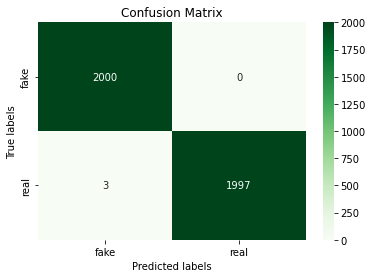

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(confmtrx, annot=True, fmt='g', ax=ax, cmap='Greens');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['fake', 'real']); ax.yaxis.set_ticklabels(['fake', 'real']);

In [47]:
fieldnames = ['LogLoss','AUC','Accuracy']
with open(r'CrossEvaluationTestScores/Image/xception_trained_on_FakeAVCeleb_evaluated_on_FakeAVCeleb.csv', 'a', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)
    writer.writeheader()
    writer.writerow({'LogLoss': logloss, 'AUC': auc, 'Accuracy': acc})

In [48]:
df = pd.read_csv('CrossEvaluationTestScores/Image/xception_trained_on_FakeAVCeleb_evaluated_on_FakeAVCeleb.csv')

In [60]:
logloss = list(df['ImagePath'])[-1]

'0.004654508359650931'

In [62]:
df

,ImagePath,ProbabilityScore,PredictedLabel,OriginalLabel
0,/Users/Sohail/Desktop/Research/PhD/Year1/NewDe...,0.999994993,1,1.0
1,/Users/Sohail/Desktop/Research/PhD/Year1/NewDe...,0.999952435,1,1.0
2,/Users/Sohail/Desktop/Research/PhD/Year1/NewDe...,0.999999046,1,1.0
3,/Users/Sohail/Desktop/Research/PhD/Year1/NewDe...,0.999985576,1,1.0
4,/Users/Sohail/Desktop/Research/PhD/Year1/NewDe...,0.99342984,1,1.0
...,...,...,...,...
3999,/Users/Sohail/Desktop/Research/PhD/Year1/NewDe...,0.004743636,0,0.0
4000,LogLoss,AUC,Accuracy,NaN
4001,0.004654508359650931,0.99999675,0.99925,NaN
4002,LogLoss,AUC,Accuracy,NaN


In [66]:
auc = list(df['ProbabilityScore'])[-1]
auc

'0.99999675'

In [65]:
acc = list(df['PredictedLabel'])[-1]
acc

'0.99925'

In [27]:
def Evaluate(model, vids_path_dict, dataset, save_path):
    
    videos = vids_path_dict[dataset][0]
    count = 0
    labels_map = ["fake", "real"]
    predictions = {}
    probs = {}
    for vid in videos:
        fake_prob = 0
        real_prob = 0
        originallabel = None
        if 'fake' in vid.split('/')[-2]:
            originallabel = 0
        elif 'real' in vid.split('/')[-2]:
            originallabel = 1
        count+=1
        print(count)
        images = sorted(glob.glob(vid + '/*.png'))
        images = [path.replace('\\','/') for path in images]
        print(len(images))
        if len(images) >= 8:
            images = images[:8]
            for image in images:
                img = Image.open(image)
                tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                                           transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                          ])
                img = tfms(img)
                with torch.no_grad():
                    outputs = model(img.unsqueeze(0).to('cuda'))
                for idx in torch.topk(outputs[0], k=1).indices.tolist():
                    prob = torch.softmax(outputs[0], 0)[idx].item()
                    if labels_map[idx] == 'fake':
                        fake_prob += prob
                        real_prob += 1-prob
                    else:
                        real_prob += prob
                        fake_prob += 1 - prob
            predicted_prob = []
            predicted_label = None
            if real_prob > fake_prob:
                predicted_prob = (real_prob/8)
                predictions[vid] = [predicted_prob, 1, originallabel]
            else:
                predicted_prob = 1 - (fake_prob/8)
                predictions[vid] = [predicted_prob, 0, originallabel]

        else:
            pass
        print('--------------')

In [28]:
Evaluate2(None, test_set_paths_dictionary, 'FakeAVCeleb', None)


/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/FakeAVCeleb_v1_2/Cleaned_Data/Images/test_set_real/id00043
1
129
